# Pose Detection with HRNet

This notebook uses an open source project [lxy5513/hrnet](https://github.com/lxy5513/hrnet) to detect/track multi person poses on a given youtube video. The original HRNet code was [here](https://github.com/leoxiaobin/deep-high-resolution-net.pytorch).


##Install HRNet

In [6]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/lxy5513/hrnet.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install dependencies
  !git clone -q {git_repo_url}
  #!cd {project_name} && pip install -q -r requirements.txt
  !pip install -q youtube-dl EasyDict==1.7 Cython pyyaml json_tricks scikit-image yacs>=0.1.5 ipdb
  !cd {project_name}/lib && make
  


##Imports

In [7]:
import time
import matplotlib
import matplotlib.pylab as plt
from IPython.display import YouTubeVideo

# append pathes
import sys
sys.path.append(project_name)
sys.path.append(join(project_name, 'tools'))
sys.path.append(join(project_name, 'lib'))

# show the grid lines
plt.rcParams["axes.grid"] = False


## Download pretrained models

In [8]:
# define download_from_google_drive function
def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id={file_id}" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={confirm_text}&id={file_id}" -o {file_name}
  

In [9]:
# set directory and path
pretrained_model_parent_directory = 'models/pytorch/pose_coco'
pretrained_model_path = join(project_name, pretrained_model_parent_directory, 'pose_hrnet_w48_256x192.pth')


In [10]:
# download the pretrained model
if not exists(pretrained_model_path):
  !rm -rf {project_name}/models
  !mkdir -p {project_name}/{pretrained_model_parent_directory}
  download_from_google_drive('15T2XqPjW7Ex0uyC1miGVYUv7ULOxIyJI', pretrained_model_path)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   2550      0 --:--:-- --:--:-- --:--:--  2566
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  243M    0  243M    0     0   130M      0 --:--:--  0:00:01 --:--:--  177M


In [11]:
# download the YOLO weights
yolo_pretrained_model_path = join(project_name, 'lib/detector/yolo/yolov3.weights')
if not exists(yolo_pretrained_model_path):
  !cd {project_name}/lib/detector/yolo/ && wget -q https://pjreddie.com/media/files/yolov3.weights

## Detect poses on a test video

We are going to detect poses on the following youtube video:

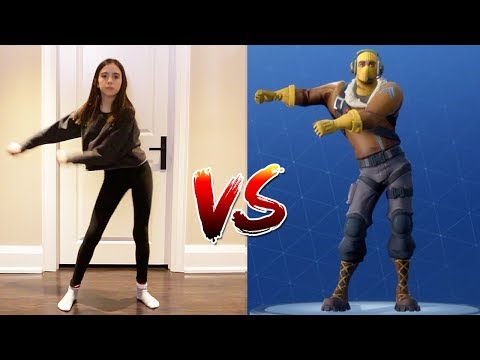

In [12]:
YOUTUBE_ID = 'RXABo9hm8B8'

YouTubeVideo(YOUTUBE_ID)

Download the above youtube video, cut the first 5 seconds:

In [13]:
!rm -df youtube.mp4
# download the youtube with the given ID
!youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID
# cut the first 5 seconds
!ffmpeg -y -loglevel info -i youtube.mp4 -t 5 video.mp4

[youtube] RXABo9hm8B8: Downloading webpage
[download] Destination: youtube.mp4
[download] 100% of 116.07MiB in 00:02
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis

Execute pose detection on the first 5 seconds:

In [14]:
# execute HRNet on video frames
import cv2
import numpy as np
from utilitys import plot_keypoint, PreProcess
from lib.core.inference import get_final_preds
import torch
import config
import models
from config import cfg, update_config
from types import SimpleNamespace


update_config(cfg,
              SimpleNamespace(cfg = join(project_name, 'experiments/coco/hrnet/w48_256x192_adam_lr1e-3.yaml'),
                              opts = '',
                              modelDir='', logDir='', dataDir='', prevModelDir=''))
def model_load(config):
  model = models.pose_hrnet.get_pose_net(config, is_train=False)
  model_file_name  = join(project_name, 'models/pytorch/pose_coco/pose_hrnet_w48_256x192.pth')
  state_dict = torch.load(model_file_name)
  from collections import OrderedDict
  new_state_dict = OrderedDict()
  for k, v in state_dict.items():
      name = k # remove module.
      #  print(name,'\t')
      new_state_dict[name] = v
  model.load_state_dict(new_state_dict)
  model.eval()
  return model

pose_model = model_load(cfg).cuda()

from lib.detector.yolo.human_detector import human_bbox_get as yolo_det
from lib.detector.yolo.human_detector import load_model as yolo_model
human_model = yolo_model()

video_capture = cv2.VideoCapture()

if video_capture.open('video.mp4'):
  width, height = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
  fps = video_capture.get(cv2.CAP_PROP_FPS)
  !rm -f output.mp4 output.avi
  # can't write out mp4, so try to write into an AVI file
  video_writer = cv2.VideoWriter("output.avi", cv2.VideoWriter_fourcc(*'MJPG'), fps, (width, height))
  while video_capture.isOpened():
    ret, frame = video_capture.read()
    if not ret:
      break
      
    start = time.time()
    
    try:
      # TODO: Yolo needs RGB?
      bboxs, scores = yolo_det(frame, human_model)
      # bbox is coordinate location
      inputs, origin_img, center, scale = PreProcess(frame, bboxs, scores, cfg)
      
      with torch.no_grad():
        # compute output heatmap
        inputs = inputs[:,[2,1,0]]
        output = pose_model(inputs.cuda()) #type : cuda
        # compute coordinate
        preds, maxvals = get_final_preds(
            cfg, output.clone().cpu().numpy(), np.asarray(center), np.asarray(scale))

      image = plot_keypoint(origin_img, preds, maxvals, 0.1)
      video_writer.write(image[:,:,::-1])
    except:
      print("no pose detected!")
      video_writer.write(frame)
    
    end = time.time()
    print("time: {}s, fps: {}".format(end-start, 1/(end-start)))
    
  video_capture.release()
  video_writer.release()
  
  !ffmpeg -y -loglevel info -i output.avi output.mp4
else:
  print("can't open the given input video file!")

Loading network.....
Network successfully loaded
time: 0.44626402854919434s, fps: 2.2408259147639638
time: 0.13274288177490234s, fps: 7.533360633949034
time: 0.12721872329711914s, fps: 7.86047819128401
time: 0.11421728134155273s, fps: 8.75524253645666
time: 0.11568999290466309s, fps: 8.643789967418117
time: 0.11127662658691406s, fps: 8.986613187981009
time: 0.11403393745422363s, fps: 8.769319224826623
time: 0.12834739685058594s, fps: 7.791353970070292
time: 0.1335461139678955s, fps: 7.488050159515686
time: 0.11863017082214355s, fps: 8.429558796634048
time: 0.12066650390625s, fps: 8.287303995953465
time: 0.11910271644592285s, fps: 8.39611412602867
time: 0.12126636505126953s, fps: 8.246309680159174
time: 0.11795783042907715s, fps: 8.477605906809687
time: 0.12260770797729492s, fps: 8.156094070245443
time: 0.12558460235595703s, fps: 7.962759615749706
time: 0.11704444885253906s, fps: 8.543762731198566
time: 0.10906291007995605s, fps: 9.169019965329014
time: 0.10545468330383301s, fps: 9.4827

Finally, visualize the result:

In [15]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4', width=960, height=720)